In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
delays_df = pd.read_csv("FlightDelays.csv")
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [3]:
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']]

In [4]:
delays_df

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,isDelayed
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,0
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,645,RU,644,EWR,199,1/31/2004,2761,DCA,0,6,31,N15555,ontime,0
2197,1700,RU,1653,EWR,213,1/31/2004,2497,IAD,0,6,31,N16976,ontime,0
2198,1600,RU,1558,EWR,199,1/31/2004,2361,DCA,0,6,31,N14902,ontime,0
2199,1359,RU,1403,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,ontime,0


In [5]:
delays_df['Flight Status'].value_counts(normalize=True)

Flight Status
ontime     0.805543
delayed    0.194457
Name: proportion, dtype: float64

In [6]:
outcome = 'isDelayed'
predictors = delays_df.columns.drop([outcome, 'FL_DATE', 'FL_NUM', 'TAIL_NUM', 'Flight Status'])
x = pd.get_dummies(delays_df[predictors], columns=['CARRIER','DEST','ORIGIN'], drop_first=True)
y = delays_df[outcome]

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
logit_reg = LogisticRegression(penalty=None, solver='newton-cg', class_weight='balanced')
logit_reg.fit(train_x, train_y)

/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(class_weight='balanced', penalty=None, solver='newton-cg')

In [11]:
variables=pd.DataFrame({'Predictor': x.columns, 'coefficient': logit_reg.coef_[0]})
intercept=pd.DataFrame({'Predictor': 'Intercept', 'coefficient': logit_reg.intercept_[0]}, index=[0])
modelParam=pd.concat([variables,intercept], ignore_index=True)
modelParam

,Predictor,coefficient
0,CRS_DEP_TIME,-0.021955
1,DEP_TIME,0.022388
2,DISTANCE,-0.704222
3,Weather,14.049008
4,DAY_WEEK,-0.057358
5,DAY_OF_MONTH,0.023076
6,CARRIER_DH,-1.704758
7,CARRIER_DL,-1.852668
8,CARRIER_MQ,-0.073695
9,CARRIER_OH,-2.675592


In [12]:
from dmba import classificationSummary

no display found. Using non-interactive Agg backend


In [13]:
classificationSummary(train_y,logit_reg.predict(train_x))

Confusion Matrix (Accuracy 0.8795)

       Prediction
Actual   0   1
     0 973  86
     1  73 188


In [14]:
classificationSummary(valid_y,logit_reg.predict(valid_x))

Confusion Matrix (Accuracy 0.8627)

       Prediction
Actual   0   1
     0 644  70
     1  51 116


In [15]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y, test_size=.4, random_state=1)

In [17]:
logit_reg_lasso = LogisticRegressionCV(cv=5,penalty='l1',solver='liblinear',class_weight='balanced',max_iter=2000)
logit_reg_lasso.fit(train_x, train_y)

variables = pd.DataFrame({'Predictor': x.columns,'coefficient': logit_reg_lasso.coef_[0]})
intercept = pd.DataFrame({'Predictor': ['Intercept'],'coefficient': [logit_reg_lasso.intercept_[0]]})
modelParam = pd.concat([variables, intercept], ignore_index=True)
print(modelParam)

print('\n\n Error on the training set:')
classificationSummary (train_y, logit_reg_lasso.predict(train_x))

print('\n\n Error on the test set:' )
classificationSummary(valid_y, logit_reg_lasso.predict(valid_x))

       Predictor  coefficient
0   CRS_DEP_TIME   -33.407671
1       DEP_TIME    51.665093
2       DISTANCE   -35.411022
3        Weather     7.634371
4       DAY_WEEK    -0.343363
5   DAY_OF_MONTH     0.690260
6     CARRIER_DH    -1.667544
7     CARRIER_DL    -1.734356
8     CARRIER_MQ     0.041227
9     CARRIER_OH    -2.651440
10    CARRIER_RU    -0.808182
11    CARRIER_UA    -1.904188
12    CARRIER_US    -1.077958
13      DEST_JFK     8.773508
14      DEST_LGA     9.190560
15    ORIGIN_DCA    17.277996
16    ORIGIN_IAD    26.547661
17     Intercept   -13.008736


 Error on the training set:
Confusion Matrix (Accuracy 0.8795)

       Prediction
Actual   0   1
     0 973  86
     1  73 188


 Error on the test set:
Confusion Matrix (Accuracy 0.8627)

       Prediction
Actual   0   1
     0 644  70
     1  51 116


In [18]:
pivot_table = pd.pivot_table(delays_df, values= 'isDelayed', index= 'CARRIER', columns= 'ORIGIN', aggfunc='mean',fill_value=0)
pivot_table

ORIGIN,BWI,DCA,IAD
CARRIER,,,
CO,0.000000,0.276596,0.000000
DH,0.000000,0.185185,0.251908
DL,0.000000,0.121134,0.000000
MQ,0.000000,0.271186,0.000000
OH,0.133333,0.000000,0.000000
RU,0.286957,0.172840,0.251908
UA,0.000000,0.000000,0.161290
US,0.000000,0.086634,0.000000


In [19]:
pivot_table = pd.pivot_table(delays_df, values='isDelayed', index='DEST', columns='ORIGIN',aggfunc='mean',fill_value=0)
pivot_table

ORIGIN,BWI,DCA,IAD
DEST,,,
EWR,0.286957,0.210938,0.251701
JFK,0.133333,0.268456,0.193237
LGA,0.000000,0.131606,0.302703


In [20]:
import matplotlib.pyplot as plt

In [21]:
delays_df['CRS_DEP_TIME_BIN']=round(delays_df['CRS_DEP_TIME']/100).astype('int')

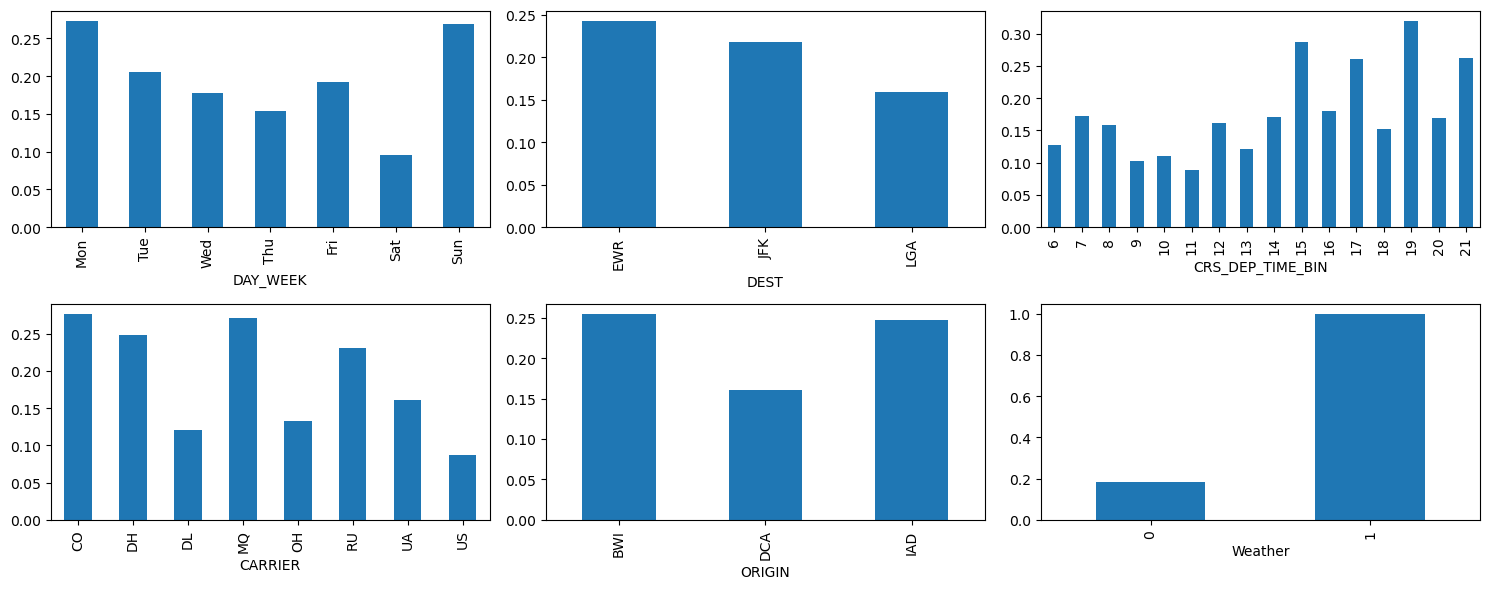

In [22]:
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))

delays_df.groupby(['DAY_WEEK'])['isDelayed'].mean().plot(kind='bar', ax=axes[0][0])
delays_df.groupby(['DEST'])['isDelayed'].mean().plot(kind='bar', ax=axes[0][1])
delays_df.groupby(['CRS_DEP_TIME_BIN'])['isDelayed'].mean().plot(kind='bar', ax=axes[0][2])
delays_df.groupby(['CARRIER'])['isDelayed'].mean().plot(kind='bar', ax=axes[1][0])
delays_df.groupby(['ORIGIN'])['isDelayed'].mean().plot(kind='bar', ax=axes[1][1])
delays_df.groupby(['Weather'])['isDelayed'].mean().plot(kind='bar', ax=axes[1][2])
axes[0][0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()


In [23]:
delays_df['Morning'] = [1 if r in (6,7,8,9) else 0 for r in delays_df['CRS_DEP_TIME_BIN']]
delays_df['Noon'] = [1 if r in (10,11,12,13) else 0 for r in delays_df['CRS_DEP_TIME_BIN']]
delays_df['Afternoon'] = [1 if r in (14,15,16,17,18) else 0 for r in delays_df['CRS_DEP_TIME_BIN']]
delays_df['Evening'] = [1 if r in (19,20,21) else 0 for r in delays_df['CRS_DEP_TIME_BIN']]

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
outcome = 'isDelayed'
drop_cols = ['FL_DATE', 'FL_NUM', 'TAIL_NUM', 'Flight Status', outcome]
predictors = delays_df.columns.drop(drop_cols)

In [26]:
x = pd.get_dummies(delays_df[predictors], columns=['CARRIER', 'DEST', 'ORIGIN'])
y = delays_df[outcome]

In [27]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=42)

In [43]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf_model.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [29]:
print('\n\n Error on the training set:')
classificationSummary(train_y, rf_model.predict(train_x))



 Error on the training set:
Confusion Matrix (Accuracy 0.9727)

       Prediction
Actual    0    1
     0 1034   21
     1   15  250


In [30]:
print('\n\n Error on the test set:')
classificationSummary(valid_y, rf_model.predict(valid_x))



 Error on the test set:
Confusion Matrix (Accuracy 0.8536)

       Prediction
Actual   0   1
     0 667  51
     1  78  85


In [31]:
print('\n\n Confusion Matrix:')
print(confusion_matrix(valid_y, rf_model.predict(valid_x)))



 Confusion Matrix:
[[667  51]
 [ 78  85]]


In [32]:
print('\n\n Classification Report:')
print(classification_report(valid_y, rf_model.predict(valid_x)))



 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       718
           1       0.62      0.52      0.57       163

    accuracy                           0.85       881
   macro avg       0.76      0.73      0.74       881
weighted avg       0.85      0.85      0.85       881



In [33]:
from xgboost import XGBClassifier

In [34]:
outcome = 'isDelayed'
drop_cols = ['FL_DATE', 'FL_NUM', 'TAIL_NUM', 'Flight Status', outcome]
predictors = delays_df.columns.drop(drop_cols)

In [35]:
x = pd.get_dummies(delays_df[predictors], columns=['CARRIER', 'DEST', 'ORIGIN'])
y = delays_df[outcome]

In [36]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=42)

In [40]:
xgb_model = XGBClassifier(n_estimators=100,max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(train_y == 0).sum() / (train_y == 1).sum(),random_state=42)

xgb_model.fit(train_x, train_y)

/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [41]:
print('\n\n Error on the training set:')
classificationSummary(train_y, xgb_model.predict(train_x))



 Error on the training set:
Confusion Matrix (Accuracy 0.9803)

       Prediction
Actual    0    1
     0 1032   23
     1    3  262


/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

In [42]:
print('\n\n Error on the test set:')
classificationSummary(valid_y, xgb_model.predict(valid_x))



 Error on the test set:
Confusion Matrix (Accuracy 0.8638)

       Prediction
Actual   0   1
     0 661  57
     1  63 100


/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/ethanrosenfeld/anaconda3/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead